# Writing Neural Networks

Writing neural networks using tensorflow's low level api is an essential skill for implementing most research papers.  The ability to translate from mathematical equations into code, is incredibly powerful.  Not only because you can take the work of others to a functional place, but because you can come up with your own ideas, mathematically, prove some properties and then do an implementation.  The process of reading and understanding techniques through mathematics and then implementing them in code is the most productive way to make progress in your development as a scientist and researcher.  It's also very useful for being an effective engineer.  Through mathematics we can quickly understand and verify that some property ought to hold.  Once you understand the definitions and consequences of an idea in mathematics, verification of it's validity often takes a day or so, much faster than the verification of scientific quantities, because mathematics works in the world of absolute truth.  This means there aren't really grey areas, so you can make definitive statements.  While in general, science does not follow this binary notion of absolutes, hence the extensive use of statistics, scientific tools are primarily written in the language of mathematics.  A given idea or theory (of the real world) may seem enticing, but without scientific evidence to back it up, the theory means little. 

That said, once a theory can be validated through statistical analysis, it can be folded into a theoretical analysis.  It is from time to time even possible to draw conclusions beyond the phenomenon of inquiry which guides future discovery.  This has been seen several times from the world of mathematical physics.  One striking example of this is the discovery of blackholes which were theorized a century before they were physically discovered.

Note: If you don't know how to write tensorflow code, please see [this](https://github.com/EricSchles/datascience_book/blob/master/python_programming/tensorflow_basics/Tensorflow%20Basics.ipynb) notebook.  

## The Neural Network framework

If you aren't already familar with neural networks, I suggest reading [this chapter](https://github.com/EricSchles/datascience_book/blob/master/5/An%20Introduction%20to%20Neural%20Networks%20-%2007.ipynb) first.  

In general, neural nets are essentially a collection of linear regression models tied together through a meta optimization algorithm called backpropagation.  The linear regression models are sometimes tied together with an 'activation' function, which is just a secondary transform applied after the linear regression optimization takes place.  We've already seen that we can use stochastic gradient descent to optimize a linear regression model [here](https://github.com/EricSchles/datascience_book/blob/master/2/An%20Introduction%20to%20Regression%20-%2003.ipynb) and that there is a linear algebra equivalent [here](https://github.com/EricSchles/datascience_book/blob/master/5/An%20Introduction%20to%20Neural%20Networks%20-%2007.ipynb).  Neural networks essentially tie these two ideas together and do _both_ optimization strategies.  The linear algebra optimization strategy happens locally with the so called 'forward pass' and then the gradient is used explicitly to update the weights on the 'backward pass'.  But keep in mind there are two optimizations working together in tandem.  

So really a neural network is just an ensemble of sort of linear models or models with easy derivates and each 'layer' of the network is just a given model, optimizing a bit of the ensemble in an explicit way.  The power of neural networks come from their flexability.  Unlike random forests or gradient boosted trees which either optimize in parallel or in sequence, neural networks can do both.  Some of the layers can optimize for certain inputs and others can optimize for others.  Or we can feed copies of the same data to a very wide neural network, which essentially acts like a random forest.  We'll see a number of architectures and ideas in this chapter for how to write down different neural network architectures, EVEN if they aren't necessarily useful, it's still good practice to see how to work with these different tools.

## A first primitive example

Our first example is going to be a purely linear model that simply does essentially linear regression.

In [44]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

class LinearRegression:
    def __init__(self, shape, learning_rate=0.5):
        array = np.random.normal(0, 1, size=shape)
        array = tf.cast(array, tf.float32)
        self.weights = tf.Variable(array)
        self.bias = tf.Variable(1.0)
        self.learning_rate = learning_rate
        
    def predict(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias
    
    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def update_weights(self, X_train, y_true):
        with tf.GradientTape() as tape:
            y_pred = self.predict(X_train)
            loss = self.loss(y_pred, y_true)
        gradients = tape.gradient(
            loss, [self.weights, self.bias]
        )
        self.weights.assign_sub(gradients[0] * self.learning_rate)
        self.bias.assign_sub(gradients[1] * self.learning_rate)

X, y = make_regression()
X_train, X_test, y_train, y_test = train_test_split(X, y)
epochs = 10
lin_reg = LinearRegression(X_train.shape[1])
X_train = tf.cast(
    tf.constant(X_train), 
    tf.float32
)
X_test = tf.cast(
    tf.constant(X_test),
    tf.float32
)
y_train = tf.cast(
    tf.constant(y_train),
    tf.float32
)
y_test = tf.cast(
    tf.constant(y_test),
    tf.float32
)
for i in range(epochs):
    lin_reg.update_weights(X_train, y_train)
    
y_pred = lin_reg.predict(X_test)
loss = lin_reg.loss(y_pred, y_test)
print("MSE:", loss)

MSE: tf.Tensor(27385605000000.0, shape=(), dtype=float32)


There are a couple of things to note here which are mandatory in order for tensorflow to train a mode successfully:

1. You must cast everything to the same type - as an exercise try copy/pasting the above code into a new cell and remove all the type casting (the code with tf.cast).  It fails because all the X, y data is treated as doubles, not floats.

2. You must call predict and your loss function inside of the gradient tape context but must apply your gradient updates outside the gradient tape context.  This choice has always felt somewhat arbitrary to me.  However, because of how distributed training works and the fact that only some variables are *trainable* while others are frozen, we need some way to manage state.  It's an annoying trade off, but it needed to be made somewhere.  Fortunately, the code is not particularly ugly, just very pedantic

3. In general tensors products are not commutative, so the order of your parameters in your tensor product matter.  This can be seen in the predict function defined above.  If we tried changing around the order then our code would not work.

4. Notice the use of tf.Variable for our weights and bias term.  If we made those tf.constant instead, then our gradient tape wouldn't let us update our variables.

These basic concerns may seem like an impedement, but this code is far cleaner and scalable than the vanilla numpy implementation found [here in the section: A Naive Implementation of a Neural Network](https://github.com/EricSchles/datascience_book/blob/master/5/An%20Introduction%20to%20Neural%20Networks%20-%2007.ipynb).  Also, we don't need to worry about figuring out the derivative for each of our activation functions.  While some people love calculus (like myself, yes even in higher dimensions), many programmers don't.  Which is why automatic differentiation implemented in packages like tensorflow has openned up a world of mathematics to programmers.  

Now that we've seen how the tensorflow framework can be used to train a neural network, let's do a multilayer preceptron.  This will be our first multilayer neural network or ensemble of layers.  We'll look at a deep neural network first, deep because it trains the layers in sequence.  And then we'll look at a wide neural network, because it will train the layers in parallel.

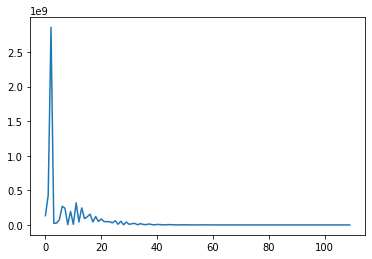

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        
    def __call__(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out)
        self.layer_two = Dense(X_out)
        self.layer_three = Dense(X_out, final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res = self.layer_one(x)
        res = self.layer_two(res)
        return self.layer_three(res)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )

    learning_rate = 0.9
    optimizer = tf.optimizers.Adam(learning_rate)
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 110
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

Some things to note here that may not be obvious:

1. We need to pass the collection of trainable variables to our gradient, otherwise they won't update explicitly.  We did do this in the first example, but this is more formalized now.  Notice, tensorflow expects the weights in order AND the ordering is expected to be weights then bias for each layer.

2. We must past the output of the previous layer into the next layer as input

3. Now we make use of the adam optimizer to update our weights through gradient update

4. We generalize our sub-models into a layer object called Dense, which does linear regression layer by layer.  

5. We only want one output vector, our predictions for the final layer, so we need to pass an optional parameter called final to our Dense object, which acts like linear regression.  All the layers before output a square weight matrix.  

Note: In this way we can see that neural networks actually do a series of optimization steps in sequence, where each additional layer after the first essentially starts with an optimized version of the previous layer (through the matrix multiplication) and then the optimization procedure itself more or less gets updated on the backward pass.  So we can think of a neural network as optimizing an optimization through backpropagation.

Now let's see a wide neural network:

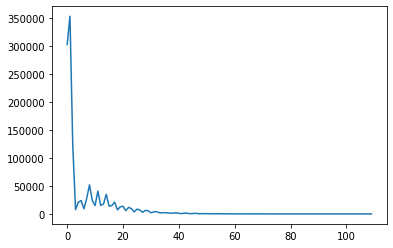

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        
    def __call__(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out)
        self.layer_two = Dense(X_out)
        self.layer_three = Dense(X_out, final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res_one = self.layer_one(x)
        res_two = self.layer_two(x)
        average_weights = tf.reduce_mean(
            [res_one, res_two], axis=0
        )
        return self.layer_three(average_weights)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )
    
    learning_rate = 0.9
    optimizer = tf.optimizers.Adam(learning_rate)
    
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 110
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

This is the first strategy we see for optimizing a wide network - take the average of the weights at each update step.  We could also sum the weights:

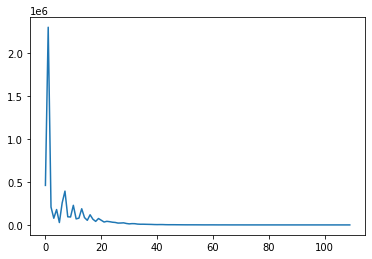

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        
    def __call__(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out)
        self.layer_two = Dense(X_out)
        self.layer_three = Dense(X_out, final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res_one = self.layer_one(x)
        res_two = self.layer_two(x)
        average_weights = tf.reduce_sum(
            [res_one, res_two], axis=0
        )
        return self.layer_three(average_weights)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )
    
    learning_rate = 0.9
    optimizer = tf.optimizers.Adam(learning_rate)
    
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 110
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

And finally we can do a reduce multiply:

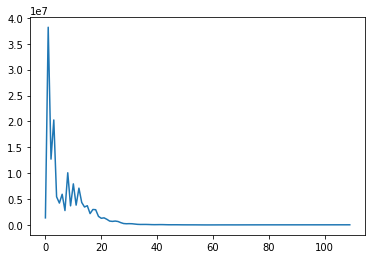

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        
    def __call__(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out)
        self.layer_two = Dense(X_out)
        self.layer_three = Dense(X_out, final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res_one = self.layer_one(x)
        res_two = self.layer_two(x)
        average_weights = tf.reduce_prod(
            [res_one, res_two], axis=0
        )
        return self.layer_three(average_weights)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )
    
    learning_rate = 0.9
    optimizer = tf.optimizers.Adam(learning_rate)
    
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 110
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

As you can see, all three methods produce more or less the same result.  Averaging seems to be the most obvious way to build wide networks, although summing is probably the fastest training time is a concern.  

Now that we've seen a number of variations of general network patterns, let's begin to add non-linearities, we'll only do this for deep neural networks because the ideas are obvious and translate directly to wide networks:

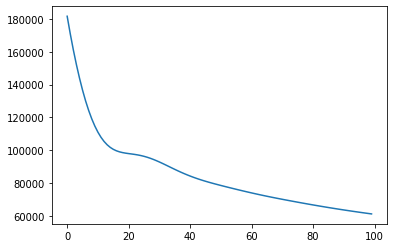

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from tensorflow.nn import (
    tanh,
    leaky_relu,
    silu,
    relu,
    selu
)
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, activation='linear', name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        self.activation_name = activation
        
    def get_activation(self):
        activation_map = {
            'linear': None,
            'tanh': tanh,
            'leaky_relu': leaky_relu,
            'silu': silu,
            'relu': relu,
            'selu': selu
        }
        return activation_map[self.activation_name]
        
    def __call__(self, x):
        activation = self.get_activation()
        if activation:
            return activation(tf.tensordot(x, self.weights, axes=1)) + self.bias
        else:
            return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out, activation='relu')
        self.layer_two = Dense(X_out, activation='selu')
        self.layer_three = Dense(X_out, activation='linear', final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res = self.layer_one(x)
        res = self.layer_two(res)
        return self.layer_three(res)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )

    learning_rate = 1e-3
    optimizer = tf.optimizers.Adam(learning_rate)
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 100
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

As you can see, adding non-linearities to our network is very easy!  We simply add it after we do our linear optimization through our dot product and we are essentially done!

Let's do a quick review of the shapes of our non-linearities:

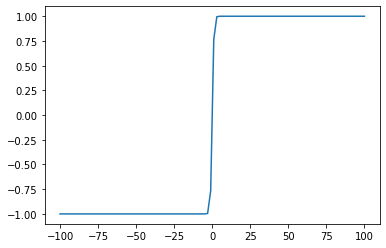

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-100, 100, num=100)
y = tanh(x)
plt.plot(x, y)

As you can see, the tanh function basically collapses our outputspace between -1 and 1 despite how big our predictions get.  This is great for dealing with exploding gradients.

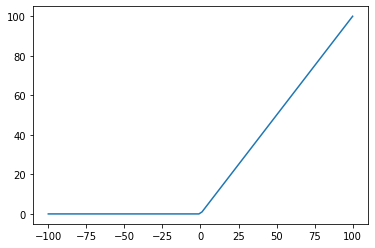

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-100, 100, num=100)
y = relu(x)
plt.plot(x, y)

The ReLU function is piece-wise linear with a discontinuity at zero.  This allows us to linear sort of a 'tree' like structure for our data with the discontinuity acting like a break so we can fit a series of smaller linear sections with our models.  This turns out to be very flexible.

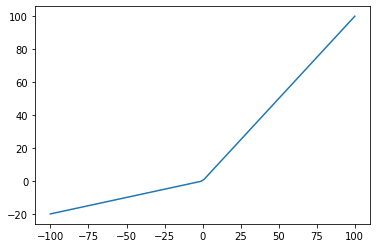

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-100, 100, num=100)
y = leaky_relu(x)
plt.plot(x, y)

Leaky ReLU retains the discontinuity so that we can have a 'smooth' piecewise linear model.  But the tail of the function is more flexible allowing us to fit more curvy functions.  This added flexibility can be both a benefit or negative.  It's best to use Leaky ReLUs on data with lots of breaks and changes in the second derivative.

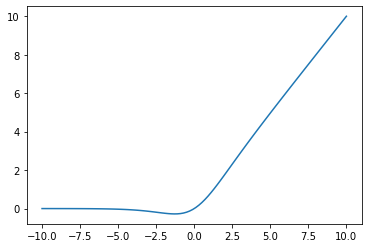

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, num=100)
y = silu(x)
plt.plot(x, y)

The SiLU activation function is slightly curvier than ReLU but basically has the same idea.  This function makes use of a sigmoid.

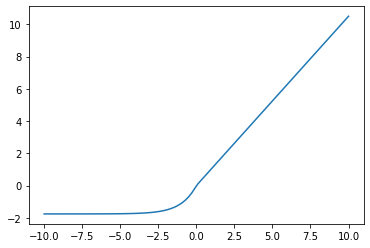

In [15]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, num=100)
y = selu(x)
plt.plot(x, y)

The SeLU is pretty similar to the SiLU activation function and accomplishs more or less the same thing except it uses a scaling factor and simple exponential instead of a sigmoid.  Notice also the SeLU drops down to -2 to instead of 0, so it's a little more flexible and a little faster.

## An introduction to time series modeling

One of the major types of data, that's easy to work with but still has some kind of structure, is time series data.  We won't do anything exhaustive here because [this chapter](https://github.com/EricSchles/datascience_book/blob/master/6/Introduction%20to%20timeseries%20modeling.ipynb) exists.

But we will use the same dataset.  So, time series data is data that occurs _over time_.  Things like the stock market or weather occur in this sequential form.  We'll be looking at stock market data for our purposes.

In [2]:
# uncomment this line and run if you don't have these libraries installed already
# !python -m pip install yfinance requests pandas_datareader

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

df = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2023-04-30")

[*********************100%***********************]  1 of 1 completed


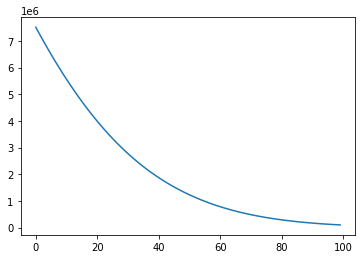

102815.93


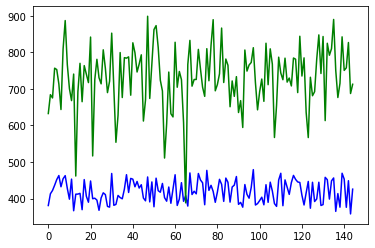

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
import tensorflow as tf

def generate_dataset(df, column, shift_range=7):
    for i in range(1, shift_range):
        shift = i * -1
        df[f"{column}_shifted_{i}"] = df[column].shift(shift)
    columns = df.columns.tolist()
    columns = [col for col in columns if column in col]
    return df[columns].dropna()

sample = df[df.index.year > 2020]
open_training = generate_dataset(sample, "Open", shift_range=7)

y = open_training["Open"]
open_training = open_training.drop("Open", axis=1)
X = open_training
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = tf.cast(
    tf.constant(X_train), 
    tf.float32
)
X_test = tf.cast(
    tf.constant(X_test),
    tf.float32
)
y_train = tf.cast(
    tf.constant(y_train),
    tf.float32
)
y_test = tf.cast(
    tf.constant(y_test),
    tf.float32
)

learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate)
model = NeuralNet(1000, X_train.shape[1], optimizer)
num_steps = 100
losses = []
for step in range(num_steps):
    model.step(X_train, y_train)
    pred = model(X_test)
    loss = model.loss(pred, y_test)
    losses.append(loss)
plt.plot(losses)
plt.show()
y_pred = model(X_test)
print(mean_squared_error(y_pred, y_test))
X_test = pd.DataFrame(X_test.numpy())
viz_results_df = X_test.copy()
viz_results_df["y_test"] = y_test.numpy()
viz_results_df["y_pred"] = y_pred.numpy()
viz_results_df.sort_index(inplace=True)

plt.plot(list(viz_results_df.index), list(viz_results_df["y_test"].values), color="blue")
plt.plot(list(viz_results_df.index), list(viz_results_df["y_pred"].values), color="green")

As you can see, our neural network does pretty shabby, that's because it's not good at learning the over time structure of our time series.  Is all hope lost?!  Nope!  There are explicit neural network architectures for dealing with data that comes with an inherent 'structure' like time series.  These architectures are:

* convolutional neural networks
* involutional neural networks
* recurrent neural networks
* transformer neural networks
* graph neural networks

There are a few more semi famous ones, but CNN, RNN, graph, and transformer are the major ones.  I included the involution because I think it's a super neat architecture and doesn't get enough love.  It's worth noting these architectures can work with higher dimension data, that is data that's organized as a three tensor or higher.  We won't go into that here, but perhaps in a future chapter!

Anywho, let's start with convolutions since those are the easiest to understand!

## Convolutional Neural Network

The convolution is a fairly simple idea, it's basically sort of like a more flexible average.  It can be used for lots of things, but it's easiest to start here and we'll build up more intuition over time.  For the purposes of programming these things, we'll only work with a discrete convolution.  The continuous case just exchanges sums for integration, so pretty standard, and essentially all the intuition just carries over.  Let's start with the mathematical description of a convolution:

$$ \sum_{0}^{n}{f(n) * g(m - n)} $$

Basically, we have some kernel function (the term kernel function gets used in a lot of places, often times in machine learning it measures the similarity or dissimilarity between two points however not here) which takes in a given index and then outputs a value.  Then we have some other function, which in our case will be our data.  Let's write down a specific convolution and then run it over our data:

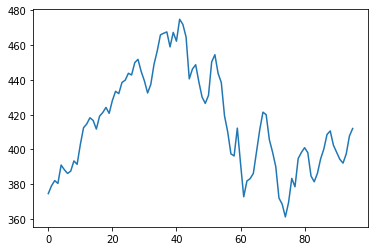

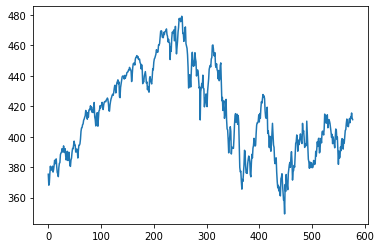

In [26]:
import matplotlib.pyplot as plt

def f(size):
    return 1/size

def convolve(x, window_size=6):
    convolved = []
    prev_i = 0
    for i in range(window_size, len(x), window_size):
        f_x = f(window_size)
        res = f_x * x[prev_i:i]
        convolved.append(sum(res))
        prev_i = i
    return convolved

res = convolve(y)
index = list(range(len(res)))
plt.plot(index, res)
plt.show()
index = list(range(len(y)))
plt.plot(index, np.array(y))

Here we pick a kernel which basically does the moving average - each of the values is multiplied by the size of the window and then everything is summed.  But we need not pick the same value or even a number less than one for our kernel.  All that matters is that every element in our window is sent somewhere.  So this is just as valid:

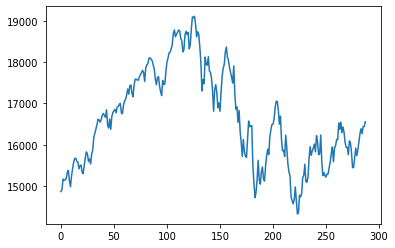

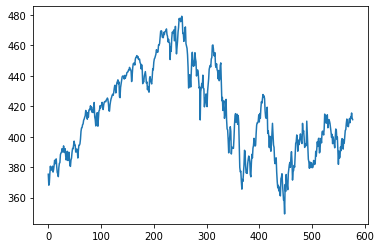

In [29]:
import matplotlib.pyplot as plt

def f(size):
    return size * 10

def convolve(x, window_size=2):
    convolved = []
    prev_i = 0
    for i in range(window_size, len(x), window_size):
        f_x = f(window_size)
        res = f_x * x[prev_i:i]
        convolved.append(sum(res))
        prev_i = i
    return convolved

res = convolve(y)
index = list(range(len(res)))
plt.plot(index, res)
plt.show()
index = list(range(len(y)))
plt.plot(index, np.array(y))

Notice, that as our window size gets smaller, we recover more and more of our original pattern.  And the larger our window size, the more of a smoothed summary we are working with.  This is the power of convolutions, we get a local 'scaled' summary of our data.  It's clearly capable of handling non-linear data, despite being a 'linear' function.  It's just basically 'piece-wise' linear, kind of like the ReLU, since it glues together windows of data, so global patterns persist.  

In a convolutional neural network, the kernel is learned to optimize the deformation from one signal into the predicted signal.  Other than that, there really isn't anything new here.  Let's look at an example for how to code one of these up!

We'll start by looking at tensorflow's built in convolve method:

In [5]:
help(tf.nn.conv1d)

Help on function conv1d_v2 in module tensorflow.python.ops.nn_ops:

conv1d_v2(input, filters, stride, padding, data_format='NWC', dilations=None, name=None)
    Computes a 1-D convolution given 3-D input and filter tensors.
    
    Given an input tensor of shape
      `batch_shape + [in_width, in_channels]`
    if `data_format` is `"NWC"`, or
      `batch_shape + [in_channels, in_width]`
    if `data_format` is `"NCW"`,
    and a filter / kernel tensor of shape
    `[filter_width, in_channels, out_channels]`, this op reshapes
    the arguments to pass them to `conv2d` to perform the equivalent
    convolution operation.
    
    Internally, this op reshapes the input tensors and invokes `tf.nn.conv2d`.
    For example, if `data_format` does not start with `"NC"`, a tensor of shape
      `batch_shape + [in_width, in_channels]`
    is reshaped to
      `batch_shape + [1, in_width, in_channels]`,
    and the filter is reshaped to
      `[1, filter_width, in_channels, out_channels]`.
    

This looks pretty reasonable!  Let's look at the expected shape for the filter and the data via an example.  Then we'll be ready to write a convolutional layer!

In [8]:
import numpy as np

data, _filter = (
    np.random.normal(0,1, size=100).reshape(1, 10, 10),
    np.random.normal(0,1, size=100).reshape(1, 10, 10)
)
data = tf.cast(
    tf.constant(data), 
    tf.float32
)
_filter = tf.cast(
    tf.constant(_filter), 
    tf.float32
)
stride = 1
padding = "SAME"
res = tf.nn.conv1d(data, _filter, stride, padding)
res

<tf.Tensor: shape=(1, 10, 10), dtype=float32, numpy=
array([[[ -2.0254931 ,  -2.2417974 ,   0.51878214,  -2.5908682 ,
          -6.6008797 ,   0.5045136 ,  -0.8114885 ,  -4.967957  ,
          -0.5497129 ,   3.3487234 ],
        [ -2.8269103 ,  -2.3048804 ,  -4.0402284 ,  -4.4751935 ,
           1.078631  ,  -2.7946608 ,   3.9435031 ,  -2.4571567 ,
          -0.11305809,  -2.8713312 ],
        [ -1.484452  ,  -0.68724674,   6.419431  ,   4.055015  ,
          -9.001113  ,   3.486238  , -10.058787  ,  -0.45145866,
           2.110779  ,  -4.572446  ],
        [  0.9690869 ,  -6.9576535 ,   0.8372947 ,  -3.1651733 ,
           2.4205027 ,  -3.220695  ,   4.6720304 ,   1.1900971 ,
          -1.7742012 ,  -1.6048522 ],
        [ -0.43239865,   9.46621   ,  -4.275375  ,  -1.8224891 ,
           1.3836923 ,   0.77848154,  -0.38968948,  -5.7313175 ,
           0.3040377 ,   3.5135105 ],
        [  7.9174986 ,   2.2071528 ,  -0.9329866 ,  -2.5469716 ,
           0.41907436,  -1.1896588 ,  -0.7

Jackpot!  So now we can pass a filter and input data to a convolution and get out a convolved tensor!  Note we'll need to get rid of our artificial third dimension:

In [9]:
print(res.shape)
res = tf.reshape(res, [10, 10])
print(res.shape)

(1, 10, 10)
(10, 10)


We now have all the pieces we'll need to write our convolutional layer:

In [31]:
class Conv2D(tf.Module):
    def __init__(self, output_size, stride, padding, activation='linear', name=None):
        super().__init__(name=name)
        weights = np.random.normal(0, 1, size=output_size * output_size)
        weights = weights.reshape(output_size, output_size)
        weights = tf.cast(weights, tf.float32)
        weights = self._3d_reshape_tensor(self, weights)
        self.weights = tf.Variable(weights)
        self.activation_name = activation
        self.stride = stride
        self.padding = padding
        self.bias = tf.Variable(1.0)
        self.output_size = output_size
        
    def _3d_reshape_tensor(self, tensor):
        tensor_shape = list(tensor.shape)
        # adding index dimension so we can convolve
        tensor_shape.insert(0, 1)
        return tf.reshape(tensor, tensor_shape)
        
    def _2d_reshape_tensor(self, tensor):
        tensor_shape = [self.output_size, self.output_size]
        return tf.reshape(tensor, tensor_shape)
    
    def get_activation(self):
        activation_map = {
            'linear': None,
            'tanh': tanh,
            'leaky_relu': leaky_relu,
            'silu': silu,
            'relu': relu,
            'selu': selu
        }
        return activation_map[self.activation_name]
        
    def __call__(self, x):
        x = self._3d_reshape_tensor(x)
        convolved_tensor = tf.nn.conv1d(x, self.weights, self.stride, self.padding)
        convolved_tensor = self._2d_reshape_tensor(convolved_tensor)
        activation = self.get_activation()
        if activation:
            return activation(convolved_tensor) + self.bias
        else:
            return convolved_tensor + self.bias


Notice that our convolutional layer simply takes the pieces that we've already defined and joins them together.  Let's look at the `__call__` method first:

1. We reshape our 2-D into three dimensions to run our convolution.
2. Then we call our helper function to actually do the convolution, that tensorflow provides for us.
3. We then reshape back to a 2-D tensor so we can pass to the next layer
4. we get our activation and call it on our convolved tensor like normal

So basically a convolutional layer is the same thing as our regular dense layer except we do this extra convolve step, which acts like a sliding window over our data.  For data that doesn't change much from moment to moment, it's best to set the stride to be one.  But for data with lots of sparsity, it's probably best for a slightly larger stride length.  In any event, in general, the convolution smooths out or summarizes our data, making it easier to 'see' larger more generalized patterns, hence it's popularity in many architectures.

Notice there is sort of a relationship with attention, in the sense that we don't observe everything in the data, but attend to small areas at a time.  Of course, the way attention works in neural networks is completely different mechanically, but there is sort of a naive 'attention' idea here.

Without further ado here is the complete network, a CNN:

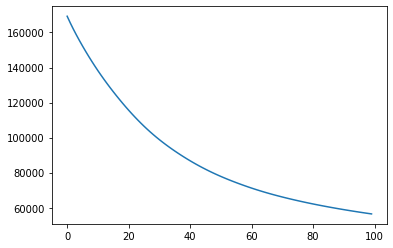

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from tensorflow.nn import (
    tanh,
    leaky_relu,
    silu,
    relu,
    selu
)
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Conv2D(tf.Module):
    def __init__(self, output_size, stride, padding, activation='linear', name=None):
        super().__init__(name=name)
        weights = np.random.normal(0, 1, size=output_size * output_size)
        weights = weights.reshape(output_size, output_size)
        weights = tf.cast(weights, tf.float32)
        weights = self._3d_reshape_tensor(weights)
        self.weights = tf.Variable(weights)
        self.activation_name = activation
        self.stride = stride
        self.padding = padding
        self.bias = tf.Variable(1.0)
        self.output_size = output_size
        
    def _3d_reshape_tensor(self, tensor):
        tensor_shape = list(tensor.shape)
        # adding index dimension so we can convolve
        tensor_shape.insert(0, 1)
        return tf.reshape(tensor, tensor_shape)
        
    def _2d_reshape_tensor(self, tensor):
        tensor_shape = list(tensor.shape)
        # first dimension is index by convention in this network
        tensor_shape = tensor_shape[1:]
        return tf.reshape(tensor, tensor_shape)
    
    def get_activation(self):
        activation_map = {
            'linear': None,
            'tanh': tanh,
            'leaky_relu': leaky_relu,
            'silu': silu,
            'relu': relu,
            'selu': selu
        }
        return activation_map[self.activation_name]
        
    def __call__(self, x):
        x = self._3d_reshape_tensor(x)
        convolved_tensor = tf.nn.conv1d(x, self.weights, self.stride, self.padding)
        convolved_tensor = self._2d_reshape_tensor(convolved_tensor)
        activation = self.get_activation()
        if activation:
            return activation(convolved_tensor) + self.bias
        else:
            return convolved_tensor + self.bias
        
class Dense(tf.Module):
    def __init__(self, output_size, activation='linear', name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        self.activation_name = activation
        
    def get_activation(self):
        activation_map = {
            'linear': None,
            'tanh': tanh,
            'leaky_relu': leaky_relu,
            'silu': silu,
            'relu': relu,
            'selu': selu
        }
        return activation_map[self.activation_name]
        
    def __call__(self, x):
        activation = self.get_activation()
        if activation:
            return activation(tf.tensordot(x, self.weights, axes=1)) + self.bias
        else:
            return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer, stride = 1, padding = "SAME"):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out, activation='relu')
        self.layer_two = Conv2D(X_out, stride, padding, activation='selu')
        self.layer_three = Dense(X_out, activation='linear', final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res = self.layer_one(x)
        res = self.layer_two(res)
        return self.layer_three(res)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )

    learning_rate = 1e-3
    optimizer = tf.optimizers.Adam(learning_rate)
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 100
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

The next thing we will look at is a popular CNN architecture, the residual network.  You may think, convolution is all you need, but in general, there are some extra tricks for designing neural networks that come in handy at the architecture level.  Networks like these help to deal with some of the potential negative consequences that can occur in neural networks like exploding or vanishing gradients.  And residual networks in particular were designed to deal with these sorts of issues.  In both regimes the network fails to learn information about the data and tends to not be useful.

In order to build a Residual Network from scratch we'll need a few ideas.  Below is a keras implementation which we will translate into low level tensorflow code:

In [11]:
def get_resnet_model():
    def residual_block(X, kernels, stride):
        out = tf.keras.layers.Conv1D(kernels, stride, padding='same')(X)
        out = tf.keras.layers.ReLU()(out)
        out = tf.keras.layers.Conv1D(kernels, stride, padding='same')(out)
        out = tf.keras.layers.add([X, out])
        out = tf.keras.layers.ReLU()(out)
        out = tf.keras.layers.MaxPool1D(2, 1)(out)
        return out

    kernels = 4
    stride = 1

    inputs = tf.keras.layers.Input([8,1])
    X = tf.keras.layers.Conv1D(kernels, stride)(inputs)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(32, activation='relu')(X)
    X = tf.keras.layers.Dense(32, activation='relu')(X)
    output = tf.keras.layers.Dense(1, activation='linear')(X)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=[mean_squared_error])

    return model

As you can see, we already have most of this implemented.  What we'll need specifically are:

* add
* maxpooling
* flatten

Let's start with the add:

As you can see, the add layer takes in the original signal and the output of the residual block right before the final ReLU.  This happens in case we have a vanishing gradient, so that not all of the signal is lost.  This always works over the original data, so even if the weights get really small we'll still capture something in the final ReLU layer, essentially making the block a piece wise linear layer if the convolution washes out too much signal through over smoothing.

In [14]:
X = tf.constant(np.random.normal(0, 1, size=100).reshape(10, 10))
out = tf.constant(np.random.normal(0, 1, size=100).reshape(10, 10))
res = tf.keras.layers.add([X, out])

In [21]:
res2 = X + out

res[0], res2[0]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([-0.16015059,  0.41206357,  1.6907461 , -0.13928151,  1.3594213 ,
         3.820858  ,  1.0799555 ,  1.2620817 , -2.9175296 , -0.4500765 ],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float64, numpy=
 array([-0.1601506 ,  0.41206359,  1.690746  , -0.13928154,  1.35942135,
         3.82085809,  1.07995542,  1.26208177, -2.91752961, -0.45007648])>)

As you can see, the add is just an element-wise addition of the two tensors, so that's fairly simple to implement.

Next let's look at the flatten:

In [31]:
X = tf.cast(X, tf.float32)
new_X = tf.cast(tf.keras.layers.Flatten()(X), tf.float32)
print(X.shape)
print(new_X.shape)
tf.math.equal(X, new_X).numpy().all()

(10, 10)
(10, 10)


True

As you can see, on a 2-D tensor this does effectively nothing.  Let's see what happens if we add more dimensions!

In [34]:
X = tf.constant(np.random.normal(0, 1, size=1000).reshape(10, 10, 10))
X = tf.cast(X, tf.float32)
new_X = tf.cast(tf.keras.layers.Flatten()(X), tf.float32)
print(X.shape)
print(new_X.shape)

(10, 10, 10)
(10, 100)


As you can see, anything over 3-D tensors are 'flattened' down to 2-D, so we technically already have that functionality just in the convolutional layer, we've made some different design choices than keras, but basically we are done there.  

The last step we need is the maxpooling layer.

More or less a maxpooling layer finds the maximum value over a grid.  Let's look at an example with a 4 x 4 x 4 3-D tensor:

In [1]:
import tensorflow as tf
import numpy as np

In [10]:
X = tf.constant(np.random.normal(0, 1, size=64).reshape(4, 4, 4))
tf.keras.layers.MaxPool1D(pool_size=4, strides=1)(X)

<tf.Tensor: shape=(4, 1, 4), dtype=float32, numpy=
array([[[ 1.1146646 ,  0.54790723,  0.8224933 , -0.11073915]],

       [[ 0.14665857,  1.3661262 ,  0.19879064,  0.8287574 ]],

       [[ 0.05237718,  1.9494268 ,  1.1538922 ,  0.00539377]],

       [[ 1.705279  ,  1.2561301 ,  0.79612565,  1.1514167 ]]],
      dtype=float32)>

The convention for max pooling in tensorflow is to treat the first axis as sort of an index dimension, representing the batch.  Then the rows are the second dimension and the columns are the third dimension.  This is the expectation for 1D data in the sense that the second dimension is typically either time or geographic area.  In general the second dimension is some differentiating 'channel' which segments the data based on something and then measures are recorded.  
The way max pooling works is by taking the max over some window of the data.  The window is always with respect to the rows so that columns are perserved, otherwise semantic information is lost.  In this case, we set the pool size equal to 4 which is the same as the number of rows, so we simply take the max of each column.  Let's verify this:

In [11]:
X = tf.constant(np.random.normal(0, 1, size=16).reshape(1, 4, 4))
for col in range(4):
    print(tf.reduce_max(X[:,:,col]))

tf.Tensor(0.4000247338073222, shape=(), dtype=float64)
tf.Tensor(0.6630748865748418, shape=(), dtype=float64)
tf.Tensor(1.1877503598451657, shape=(), dtype=float64)
tf.Tensor(1.6246577069818215, shape=(), dtype=float64)


In [12]:
tf.keras.layers.MaxPool1D(pool_size=4, strides=1)(X)

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0.40002474, 0.6630749 , 1.1877503 , 1.6246578 ]]], dtype=float32)>

As you can see, the numbers equate.  We can specify other things like the stride, which we preset as 1.  Most of the time unless you are dealing with images or time data that is sampled _super_ often you just want to set stride to 1.  The stride is how much the window should shift after taking each max from a given set of points per column.  For images, down sampling the number of pixels can be very useful for creating internal representations.  In this way RNNs and CNNs in practice become fairly similar in that both models create vectors that have increasingly large amount of information stored in a tensor.  RNNs tend to regularize this via long term short term memory, trying to create the 'best' representation that is time invariant.  While CNNs, specifically any CNN with max pooling do this by creating increasingly dense representations of data across the network, it's interesting that the most compressed representation is typically the one closest to the error update in backpropagation.  This shows that these dense representations, that capture only the biggest signals are used to update the error the most, which the nuance is captured and updates the error in increasingly small ways, which makes sense.  You want big shifts to shift your error a lot and smaller signals to shift it a little.  

The major difference between the above code and a true max pooling layer is the use of a variable sliding window.  For this, we simply index over the batch and columns, mutating the rows.  Let's see an implementation in numpy, because updating tensors in tensorflow is essentially impossible to do in an elegant way:

In [72]:
def get_pools(X, pool_size, stride):
    pools = []
    
    for i in np.arange(X.shape[0], step=stride):
        for j in np.arange(X.shape[0], step=stride):
            mat = X[i:i+pool_size, j:j+pool_size]
            
            # allows us to use the above elegant indexing
            if mat.shape == (pool_size, pool_size):
                pools.append(mat)
                
    return np.array(pools)

def max_pooling(X, pool_size=1, stride=1):
    pools = get_pools(X, pool_size, stride)
    num_pools = pools.shape[0]
    new_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))
    pooled = []
    
    for pool in pools:
        pooled.append(np.max(pool))
        
    return np.array(pooled).reshape(new_shape)

X = tf.constant(np.random.normal(0, 1, size=16).reshape(4, 4))
print(X)
print(max_pooling(X.numpy(), pool_size=2, stride=1))

tf.Tensor(
[[-1.68763552  0.6283153   1.27733028 -0.77895851]
 [-0.36371621 -0.92511613  0.42744413  1.72623987]
 [ 0.42115311  1.33209247 -0.83621317 -0.84142983]
 [-0.66444867  0.45233541  0.9729522  -0.14579753]], shape=(4, 4), dtype=float64)
[[0.6283153  1.27733028 1.72623987]
 [1.33209247 1.33209247 1.72623987]
 [1.33209247 1.33209247 0.9729522 ]]


We can manually verify this is correct by writing down each 2 x 2 matrix and then finding the max element of each pool.  As we see, this is in fact a correct implementation.  We'll use this one in our implementation since it's obvious how to reason about even if it isn't optimized for speed, our tensors are faily small and thus speed in the max pooling layer is not imperative.